# How I built an actor classifier 🎬

*Inspired By: Francisco Ingham, Jeremy Howard, [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

## Why Did I Do This?

* Have never done this before
* Start with the end in mind

## Goals of This Presentation

* A quick introduction to fast.ai courses available for free online.
* Training initial model, unfreezing, training round 2
* Evaluating model
* Putting into prod with Render

## Fast.ai

*Fast.ai* refers to both a [Python library](https://docs.fast.ai) and a [massive open online course (MOOC)](https://www.fast.ai). The Python library is built as a high-level interface on top of PyTorch. The MOOC walks newcomers through using the fast.ai Python library.

The MOOC follows a-top down approach (as opposed to the bottom-up approach of MLU).

## Convolutional Neural Network

![Deep Learning Diagram](http://john.sisler.info/wp-content/uploads/sites/2/2018/07/Neural-Network-Diagram.png)

The CNN structure used (ResNet-50) has 50 hidden layers. The first layer looking for simple shapes and gradients, and each subsequent layer looks for more and more detail. The model comes pre-trained on the huge Imagenet dataset.

## How Does The Computer See Images?

[source](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)

![Image to Matrix](https://miro.medium.com/max/581/1*zY1qFB9aFfZz66YxxoI2aw.gif)

If this were a color image, the matrix would become 18x18x3 (RGB). 

## Import and View Input Data

In [1]:
from fastai.vision import *
import pandas as pd
path = Path('data/ruffalo_messina')
path

PosixPath('data/ruffalo_messina')

#### Split Train/Test

In [2]:
np.random.seed(42)
data = ImageDataBunch.from_csv(
    path, folder=".", valid_pct=0.2, csv_labels='cleaned-toplosses.csv', ds_tfms=get_transforms(), size=224, num_workers=4
)

data = data.normalize(imagenet_stats)

#### Show Sample Images

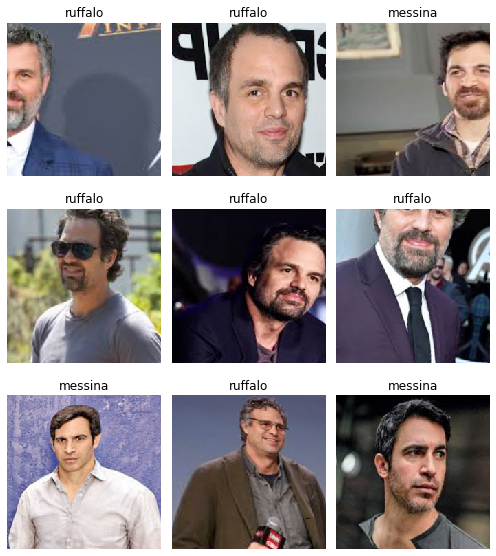

In [3]:
data.show_batch(rows=3, figsize=(7,8))

In [4]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['messina', 'ruffalo'], 2, 156, 38)

## Train Initial Model with Default Params

#### Load ResNet-50

50 layers deep, trained on over a million images from imagenet. Because we're not unfreezing anything, model only trains the last few layers of ResNet-50.

In [5]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [6]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [7]:
%time learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.239552,1.457398,0.473684,00:13
1,0.995511,2.362038,0.473684,00:03
2,0.965251,3.347929,0.473684,00:03
3,0.889500,2.470280,0.421053,00:03


CPU times: user 6.59 s, sys: 8.61 s, total: 15.2 s
Wall time: 24 s


In [8]:
learn.save('stage-1')

## Edit Only One Parameter: Learning Rate

In [9]:
learn.unfreeze()

All of the layers are trainable = True now. It sets every layer group to trainable (i.e. `requires_grad = True`).
All weights from frozen layers of the model now can get updated from their pre-trained state according to loss function. You can change this behavior by instead using `freeze_to()` method which allows you to keep some layers frozen.

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


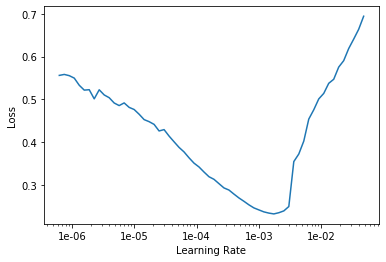

In [11]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)

learn.recorder.plot()

Learning rate is set to a slice inferred from the graph above, try to catch the slide downward. This maintains a low learning rate for initial layers as they need lesser tuning and gradually increase learning rate for later layers which need higher tuning especially fully connected ones.

In [12]:
%time learn.fit_one_cycle(15, max_lr=slice(0.00001, 0.0003))

epoch,train_loss,valid_loss,error_rate,time
0,0.678663,1.762785,0.342105,00:04
1,0.584263,1.229756,0.289474,00:04
2,0.488954,0.957942,0.210526,00:04
3,0.455347,0.786359,0.210526,00:04
4,0.389292,0.714178,0.157895,00:04
5,0.330764,0.674197,0.157895,00:04
6,0.303758,0.623301,0.131579,00:04
7,0.280969,0.535388,0.131579,00:04
8,0.253069,0.483422,0.184211,00:04
9,0.233800,0.452185,0.184211,00:04


CPU times: user 34.6 s, sys: 13.8 s, total: 48.4 s
Wall time: 1min 5s


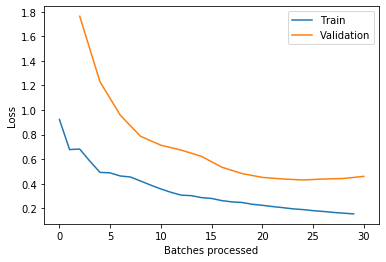

In [13]:
learn.recorder.plot_losses()

In [14]:
learn.save('stage-2')

## Interpretation

In [15]:
learn.load('stage-2');

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

How'd we do on the validation set?

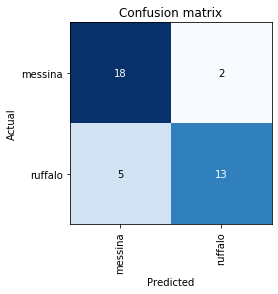

In [17]:
interp.plot_confusion_matrix()

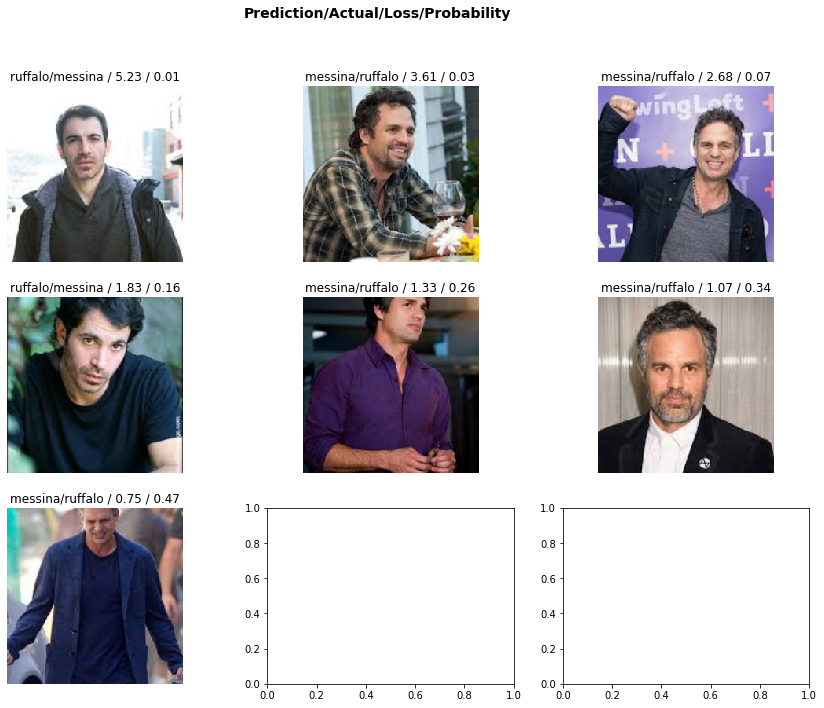

In [18]:
interp.plot_top_losses(7, figsize=(15,11))

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference (*inference == predicting in production*), except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')  # Just don't run this code if I want to do this on GPU

In [ ]:
img = open_image(path/'test'/'messina_best1.png')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)
path

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

### Learning rate (LR) too low
A rule of thumb is that your training loss (train_loss) should **never** be bigger than your validation loss (valid_loss).

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs
This leads to **underfitting**

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

### Too many epochs
This leads to **overfitting**. One clue that you're overfitting is your error rates gets better with each epoch, but then starts getting worse again. Note that the learning rate is quite small here too.

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

In [ ]:
learn.recorder.plot_losses()